# 01 - Training, Validation, Testing

We are at the moment only testing our accuracy on our test data after we submit it to Kaggle.

Submissions to Kaggle are limited, so we should rather try to test on our training data already.

What we want is to split the train data into:

1. a set we want to train on
2. a set we use only for validating our training

Let's start out with a validation set of size  **1/3**

In [3]:
%load_ext autoreload
%autoreload 2


import tools.extract as e
import tools.transform as t

train, test = e.load("data")

DATA_SIZE = len(train)
VALIDATION_SIZE = int(len(train) * 1/8)
TRAIN_SIZE = DATA_SIZE - VALIDATION_SIZE

from sklearn.utils import shuffle

shuffled = shuffle(train)

validation_set = shuffled [ TRAIN_SIZE: ]
training_set = shuffled [ :TRAIN_SIZE ]

In [4]:
import tools.extract as e
import tools.transform as t

# 'PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
# 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'

features = ['Pclass', 'Sex', 'Age']

def transform(data):
    selected = t.select(data, features)
    selected["Sex"], _ = ( t.encode_categories( selected, "Sex" ))
    selected["Age"] = t.set_NaN(selected, "Age", 0)
    return selected

import tools.classifiers.decision_tree as dt
import tools.predict as p

labels = training_set['Survived']

tree = dt.DecisionTree(features)
p.train(tree, transform(training_set), labels)

val_predictions = p.predict(tree, transform(validation_set))
train_predictions = p.predict(tree, transform(training_set))

ID = "PassengerId"
LABEL = "Survived"

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [5]:
def accuracy( predicted, ground_truth ):
    correct = (predicted == ground_truth).sum()
    print( "correct/total: " + str(correct) +"/"+ str(len(predicted)))
    print( "accuracy: " + str(correct/len(predicted)) )
    return correct/len(predicted)

print("Training data:")
accuracy(train_predictions, training_set['Survived'])
print("\n\nValidation data:")
accuracy(val_predictions, validation_set['Survived'])

Training data:
correct/total: 689/780
accuracy: 0.883333333333


Validation data:
correct/total: 91/111
accuracy: 0.81981981982


0.81981981981981977

## Cool! Now we are set to rumble!

Let us try different depth limitations for the tree

In [9]:
max_depths = list(range(1,30))

training_acc = []
validation_acc = []

for i in max_depths:
    tree = dt.DecisionTree(features, max_depth = i)
    p.train(tree, transform(training_set), labels)

    val_predictions = p.predict(tree, transform(validation_set))
    train_predictions = p.predict(tree, transform(training_set))
    
    print("Max Depth: " + str(i))
    print("Training data:")
    training_acc.append(accuracy(train_predictions, training_set['Survived']))
    print("\n\nValidation data:")
    validation_acc.append(accuracy(val_predictions, validation_set['Survived']))
    
    print("\n----------------")


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Max Depth: 1
Training data:
correct/total: 618/780
accuracy: 0.792307692308


Validation data:
correct/total: 83/111
accuracy: 0.747747747748

----------------
Max Depth: 2
Training data:
correct/total: 618/780
accuracy: 0.792307692308


Validation data:
correct/total: 83/111
accuracy: 0.747747747748

----------------
Max Depth: 3
Training data:
correct/total: 626/780
accuracy: 0.802564102564


Validation data:
correct/total: 85/111
accuracy: 0.765765765766

----------------
Max Depth: 4
Training data:
correct/total: 631/780
accuracy: 0.808974358974


Validation data:
correct/total: 87/111
accuracy: 0.783783783784

----------------
Max Depth: 5
Training data:
correct/total: 639/780
accuracy: 0.819230769231


Validation data:
correct/total: 87/111
accuracy: 0.783783783784

----------------
Max Depth: 6
Training data:
correct/total: 645/780
accuracy: 0.826923076923


Validation data:
correct/total: 87/111
accuracy: 0.783783783784

----------------
Max Depth: 7
Training data:
correct/tota

## Okay interesting... 

but now let's plot it to see how the training accuracy and the validation accuracy behave with respect to the maximum tree depth

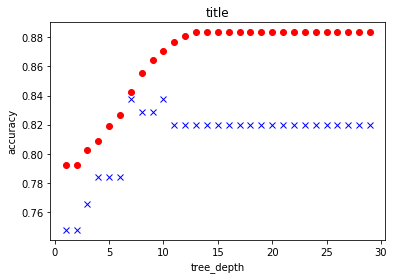

In [10]:
from pylab import *
import matplotlib.pyplot as plt

figure()
plt.plot(max_depths, training_acc, 'o', color='red')
plt.plot(max_depths, validation_acc, 'x', color='blue')

plt.xlabel('tree_depth')
plt.ylabel('accuracy')
plt.title('title')
plt.show()

As we can see best tree depth for the validation set is actually already at 7

## Problem
This highly depends on how we choose the validation set. If we resample the validation set and choose a different values, the plot changes for the validation accuracy

**Instead ..**

We can do k-fold cross validation. That means:
1. we split all the given data in k different sets.
2. for each set
    - we use that sets for validation
    - we use the rest for the training
    - we calculate the accuracy on the validation set
3. take the average over all the calculated accuracy
4. plot

**Hopefully the result will be a bit more stable!**

## Let's try 5 fold cross validation here!

In [ ]:
def get_splits(data):
    from sklearn.utils import shuffle

    shuffled = shuffle(data)

    validation_set = shuffled [ TRAIN_SIZE: ]
    training_set = shuffled [ :TRAIN_SIZE ]